<a href="https://colab.research.google.com/github/MattiaVerticchio/PersonalProjects/blob/master/CancerClassification/RNAseqCancerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Oncologic disease classification

> **Abstract**
>
> The goal of this project is to classify oncological diseases by analyzing patients’ RNAs. There are 44 features in the dataset and five classes of diseases to assign. We’ll explore different statistical and machine learning models using PyCaret as the main framework, with Scikit-Learn, XGBoost, and Microsoft LightGBM as backends. The benchmark is a paper published in 2019 on the Journal of Medical Imaging and Health Informatics. The results are in line with the paper, with improvements in accuracy and Cohen’s Kappa scores.

## Introduction
The 44 features `gene_XX` are real numbers representing gene expression levels obtained from RNA sequencing.
The target variable is a multi-class integer classification with `Class` ranging from 1 to 5.

The type of cancers in the dataset and the mappings are the following:
1. BRCA — Breast invasive carcinoma
1. KIRC — Kidney renal clear cell carcinoma
1. COAD — Colon adenocarcinoma
1. LUAD — Lung adenocarcinoma
1. PRAD — Prostate adenocarcinoma

The benchmark is [Classifying Cancer Patients Based on DNA Sequences Using Machine Learning](https://www.ingentaconnect.com/content/asp/jmihi/2019/00000009/00000003/art00005;jsessionid=8d5nnqbneb9sn.x-ic-live-02) by Hussain, Fahad & Saeed, Umair & Islam, Noman & Sheikh, Ghazala, published on Journal of Medical Imaging and Health Informatics in 2019.

### Environment Setup
First of all, we install [PyCaret](https://pycaret.org), that we’ll use as the main framework.

In [ ]:
%%bash
pip install -q pycaret

Now let’s import libraries for DataFrame management and classification.

In [ ]:
import pandas as pd                             # DataFrames 
from pycaret.classification import *            # Machine learning library
from pycaret.utils import enable_colab          # PyCaret settings for Colab
enable_colab()
%config InlineBackend.figure_format = 'retina'  # Hi-res visualization

Colab mode activated.


The data is available locally. We will read and shuffle it.

In [ ]:
df = pd.read_csv('DNA_Dataset_Normalized.csv')  # Reading the data
df = df.sample(frac=1, random_state=42)         # Dataset shuffling

df.head()                                       # Print the first lines

,gene_1,gene_2,gene_3,gene_4,gene_6,gene_7,gene_10,gene_11,gene_12,gene_13,gene_14,gene_17,gene_18,gene_19,gene_20,gene_21,gene_22,gene_23,gene_24,gene_25,gene_26,gene_27,gene_28,gene_29,gene_30,gene_31,gene_32,gene_33,gene_34,gene_35,gene_36,gene_37,gene_38,gene_39,gene_40,gene_41,gene_42,gene_43,gene_44,gene_45,gene_46,gene_47,gene_48,gene_49,Class
9,1.624335,2.880039,7.849242,9.961128,7.426315,0.000000,0.000000,0.768671,2.567083,0.0,0.000000,0.000000,0.0,7.921121,2.175876,2.384713,8.739646,0,0.0,0.000000,0.000000,10.429302,0.768671,3.239520,7.780441,1.931645,7.315512,0.000000,9.866341,7.816920,0.000000,2.728965,10.023907,0.000000,10.764216,0.0,0.0,0.0,5.385994,5.410073,10.248331,8.597486,11.650257,0.000000,1
42,4.225699,5.019471,7.412917,9.156204,7.997168,1.211884,0.000000,1.861042,0.908890,0.0,0.000000,0.000000,0.0,10.023047,4.280147,0.000000,7.495575,0,0.0,0.000000,0.000000,9.602176,0.908890,3.208642,6.987912,0.000000,7.410426,0.000000,10.887495,6.873801,0.000000,0.000000,9.245474,0.000000,9.837623,0.0,0.0,0.0,0.000000,5.757383,10.132551,9.127063,11.557330,0.000000,1
33,4.058230,2.498966,8.333777,9.915240,8.199020,0.959548,0.000000,0.558170,1.530820,0.0,0.000000,0.000000,0.0,8.828048,3.248322,0.000000,6.465775,0,0.0,0.000000,0.000000,10.162417,0.959548,3.909255,7.222293,2.106549,7.038250,0.000000,11.643577,6.240961,0.000000,0.558170,9.585194,0.558170,10.546480,0.0,0.0,0.0,0.000000,4.778866,10.112192,8.722299,11.597047,0.000000,1
311,2.448584,2.527646,6.420061,9.247954,10.015178,0.691534,2.407353,0.000000,2.708209,0.0,1.508429,1.157044,0.0,10.367873,4.678083,4.360273,9.394896,0,0.0,0.691534,11.069181,8.492510,3.169139,7.749494,0.000000,0.000000,6.973680,0.691534,13.834046,8.947257,2.026800,0.000000,9.089225,4.453531,10.491963,0.0,0.0,0.0,4.412456,7.037613,10.132063,10.781794,11.834100,0.691534,4
272,0.000000,1.622274,7.604368,10.357442,5.764221,0.000000,0.000000,0.000000,4.658223,0.0,0.759497,0.000000,0.0,7.647782,2.548437,0.000000,10.663211,0,0.0,0.000000,6.077134,9.499162,0.000000,9.889375,0.000000,0.759497,6.522596,0.000000,12.422325,8.745473,0.759497,0.000000,8.624053,0.000000,9.761174,0.0,0.0,0.0,2.158434,4.534286,9.065796,7.881915,11.242317,0.000000,4


We can store the feature names in a list to ease later preprocessing.

In [ ]:
features = df.iloc[:,:-1].columns.tolist()  # Feature names

## Comparing the Models

Now we can set up the learning environment.

The training DataFrame is `df`, with target `Class`.
I’m explicitly setting the data types as numeric to avoid inference issues. This first run of `setup` and `compare_models` will evaluate the models without performing any preprocessing on data.

I’m explicitly blacklisting Yandex CatBoost, Radial Kernel Support Vector Machine, and Gaussian Process Classifier models to avoid long training times.

In [ ]:
setup(                          # Setup the environment
    data=df,                    # Training data
    target='Class',             # Target to classify
    train_size=0.8,             # Train-Test sets split
    numeric_features=features,  # Setting the numerical features
    session_id=42,              # Seed
    verbose=False,              # Show results only
    silent=True,                # Don’t require confirmation
    use_gpu=True                # Use hardware acceleration
)

compare_models(      # Train and compare the models
    turbo=False,     # Enable all the models by default
    exclude=[        # Selectively exclude the following models:
        'catboost',  # Yandex CatBoost
        'rbfsvm',    # RBF Support Vector Machine
        'gpc'        # Gaussian Process Classifier
    ]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extra Trees Classifier,0.9455,0.0000,0.9462,0.9526,0.9442,0.9318,0.9342,0.1724
1,Linear Discriminant Analysis,0.9453,0.0000,0.9448,0.9504,0.9451,0.9315,0.9328,0.0073
2,Ridge Classifier,0.9420,0.0000,0.9419,0.9458,0.9418,0.9275,0.9285,0.0057
3,Logistic Regression,0.9356,0.0000,0.9362,0.9437,0.9346,0.9195,0.9225,0.0379
4,MLP Classifier,0.9292,0.0000,0.9286,0.9346,0.9286,0.9114,0.9131,1.0666
5,Light Gradient Boosting Machine,0.9196,0.0000,0.9195,0.9320,0.9198,0.8994,0.9025,0.2370
6,Extreme Gradient Boosting,0.9133,0.0000,0.9133,0.9250,0.9129,0.8915,0.8948,0.2526
7,K Neighbors Classifier,0.9069,0.0000,0.9062,0.9218,0.9023,0.8834,0.8885,0.0039
8,Gradient Boosting Classifier,0.8876,0.0000,0.8871,0.8993,0.8866,0.8593,0.8629,1.2895
9,SVM - Linear Kernel,0.8815,0.0000,0.8810,0.9090,0.8745,0.8515,0.8621,0.1063


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

As the next step, we can check if standardizing the data through z-score normalization increases predicting accuracy. Also, the `group_features` option aggregates specified features (in this case, all of them) and computes minimum, maximum, mean, median, and standard deviation for each observation.

In [ ]:
setup(                          # Setup the environment
    data=df,                    # Training data
    target='Class',             # Target to classify
    train_size=0.8,             # Train-Test sets split
    numeric_features=features,  # Setting the numerical features
    normalize=True,             # Z-Score normalization
    group_features=features,    # Aggregate
    session_id=42,              # Seed
    verbose=False,              # Show re
    silent=True,                # Don’t require confirmation
    use_gpu=True                # Use hardware acceleration
)

best_model = compare_models(turbo=False,     # Train and compare all the models
                            exclude=[        # Exclude the following ones:
                                'catboost',  # Yandex CatBoost
                                'rbfsvm',    # RBF Support Vector Machine
                                'gpc'        # Gaussian Process Classifier
                                ]
                            )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extra Trees Classifier,0.9487,0.0000,0.9490,0.9579,0.9477,0.9358,0.9385,0.1832
1,Ridge Classifier,0.9485,0.0000,0.9481,0.9520,0.9483,0.9355,0.9365,0.0054
2,Linear Discriminant Analysis,0.9485,0.0000,0.9481,0.9533,0.9483,0.9355,0.9367,0.0084
3,Logistic Regression,0.9356,0.0000,0.9348,0.9439,0.9345,0.9194,0.9218,0.0213
4,Light Gradient Boosting Machine,0.9164,0.0000,0.9162,0.9282,0.9163,0.8955,0.8985,0.2953
5,SVM - Linear Kernel,0.9132,0.0000,0.9129,0.9183,0.9116,0.8914,0.8936,0.1054
6,MLP Classifier,0.9131,0.0000,0.9124,0.9203,0.9111,0.8912,0.8940,0.5191
7,Extreme Gradient Boosting,0.9101,0.0000,0.9100,0.9222,0.9099,0.8875,0.8908,0.2577
8,K Neighbors Classifier,0.8941,0.0000,0.8929,0.9066,0.8863,0.8674,0.8727,0.0036
9,Gradient Boosting Classifier,0.8843,0.0000,0.8838,0.8964,0.8847,0.8551,0.8579,1.3945


The accuracy increased slightly.

## Model Tuning

Once we set up the learning environment and pre-processed the data, we can explore the hyperparameter space and tune the top-performing model.

In [ ]:
tuned_model = tune_model(best_model,         # Tune the chosen model
                         n_iter=100,         # Try n_iter different models
                         choose_better=True  # Keep the best model
                         )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9062,0.0000,0.9095,0.9219,0.9055,0.8829,0.8873
1,0.9062,0.0000,0.9143,0.9263,0.8991,0.8831,0.8907
2,0.8710,0.0000,0.8667,0.8957,0.8603,0.8383,0.8472
3,0.9032,0.0000,0.9095,0.9124,0.9003,0.8792,0.8827
4,0.8065,0.0000,0.8238,0.8587,0.7803,0.7594,0.7776
5,0.9677,0.0000,0.9667,0.9724,0.9675,0.9596,0.9609
6,0.8065,0.0000,0.8000,0.7907,0.7898,0.7575,0.7615
7,0.8387,0.0000,0.8381,0.8675,0.8330,0.7982,0.8056
8,0.8710,0.0000,0.8667,0.8842,0.8584,0.8383,0.8450
9,0.9032,0.0000,0.9000,0.9165,0.8989,0.8787,0.8834


In [ ]:
calibrated_model = calibrate_model(tuned_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9688,0.0000,0.9667,0.9727,0.9684,0.9608,0.9620
1,0.9375,0.0000,0.9429,0.9464,0.9347,0.9220,0.9253
2,0.9032,0.0000,0.9000,0.9222,0.9006,0.8786,0.8844
3,0.9355,0.0000,0.9429,0.9447,0.9326,0.9195,0.9231
4,0.9355,0.0000,0.9429,0.9516,0.9347,0.9195,0.9243
5,0.9355,0.0000,0.9333,0.9516,0.9372,0.9193,0.9229
6,0.9355,0.0000,0.9333,0.9516,0.9336,0.9193,0.9241
7,0.9677,0.0000,0.9667,0.9724,0.9675,0.9596,0.9609
8,0.9355,0.0000,0.9333,0.9355,0.9355,0.9193,0.9193
9,0.9677,0.0000,0.9667,0.9724,0.9675,0.9596,0.9609


# Model Testing

After the calibration, we can apply the model to the test set and confront the results with the paper we took as the benchmark.

In [ ]:
prediction = predict_model(calibrated_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Calibrated Classifier C V,0.9103,0,0.91,0.922,0.9126,0.8878,0.8899


The reference paper presents a Random Forest Classifier as the best predicting model. We can see our classifier performances are in line with it and slightly outperform the benchmark.

In [ ]:
paper_accuracy = 0.9402
paper_kappa    = 0.9249

accuracy_change = 0.9487 - paper_accuracy
kappa_change    = 0.9359 - paper_kappa

print(f'The accuracy increase is {round(100 * accuracy_change, 2)}%.')
print(f'The Cohen\'s Kappa increase is {round(100 * kappa_change, 2)}%.')

The accuracy increase is 0.85%.
The Cohen's Kappa increase is 1.1%.


## Visualizing the Model

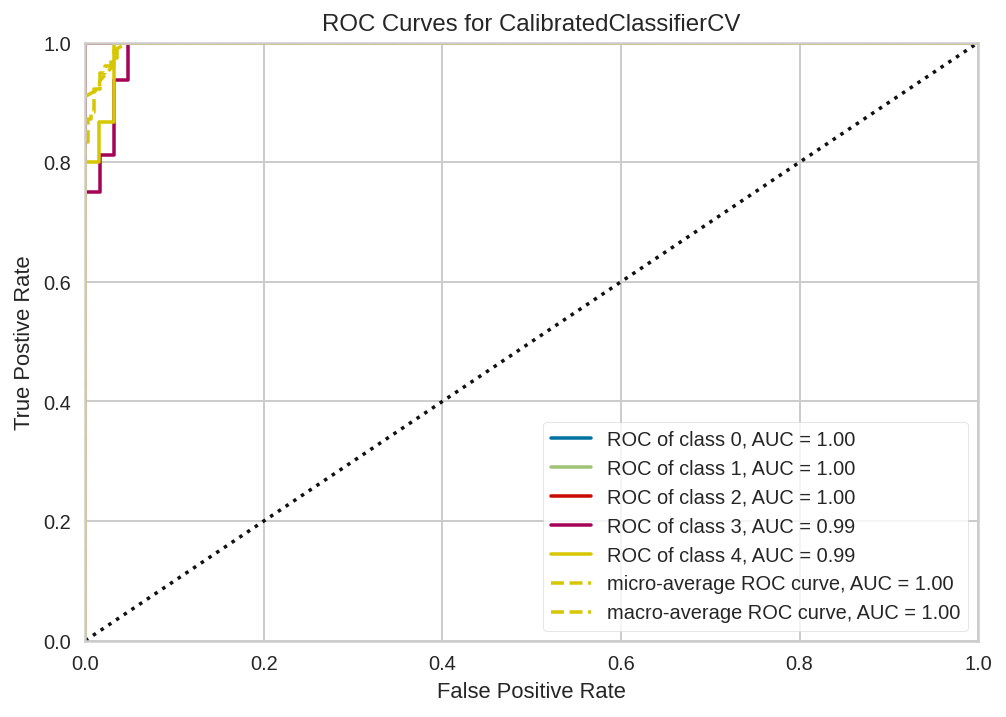

In [ ]:
plot_model(
    calibrated_model,
    plot='auc'
)

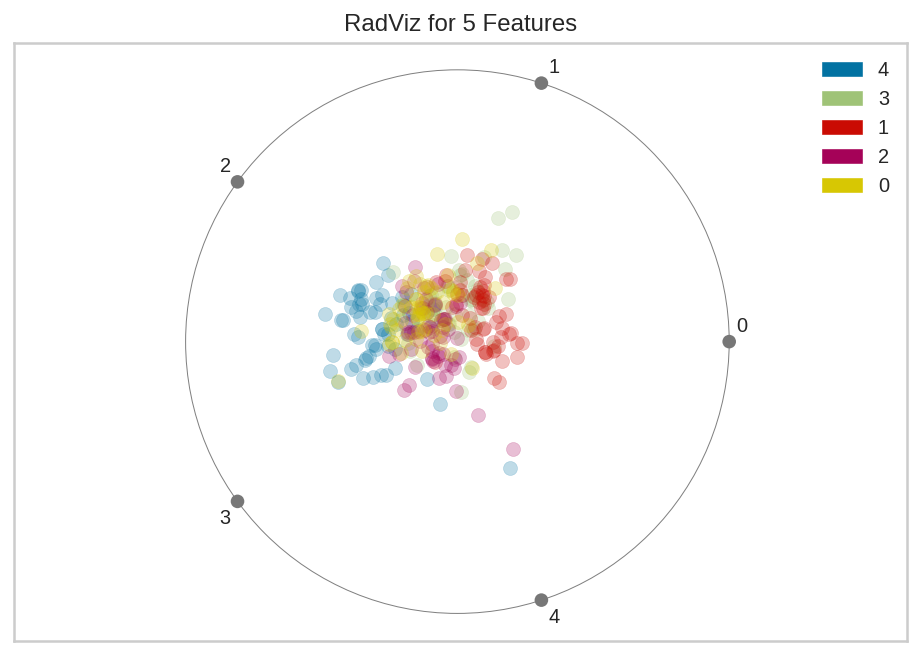

In [ ]:
plot_model(
    calibrated_model,
    plot='dimension'
)

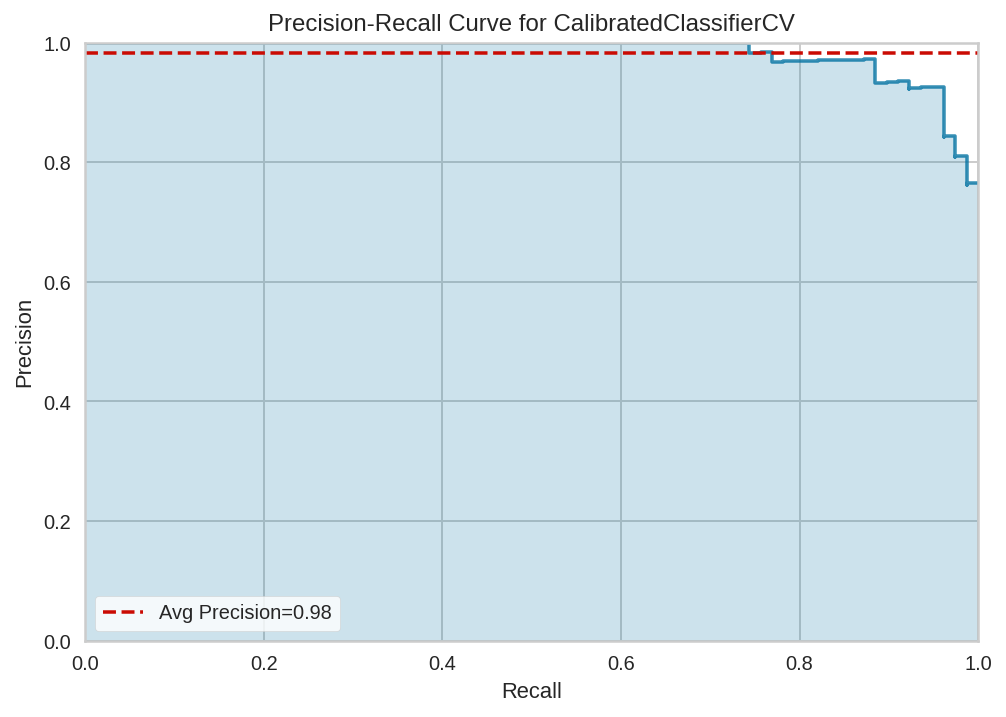

In [ ]:
plot_model(
    calibrated_model,
    plot='pr'
)

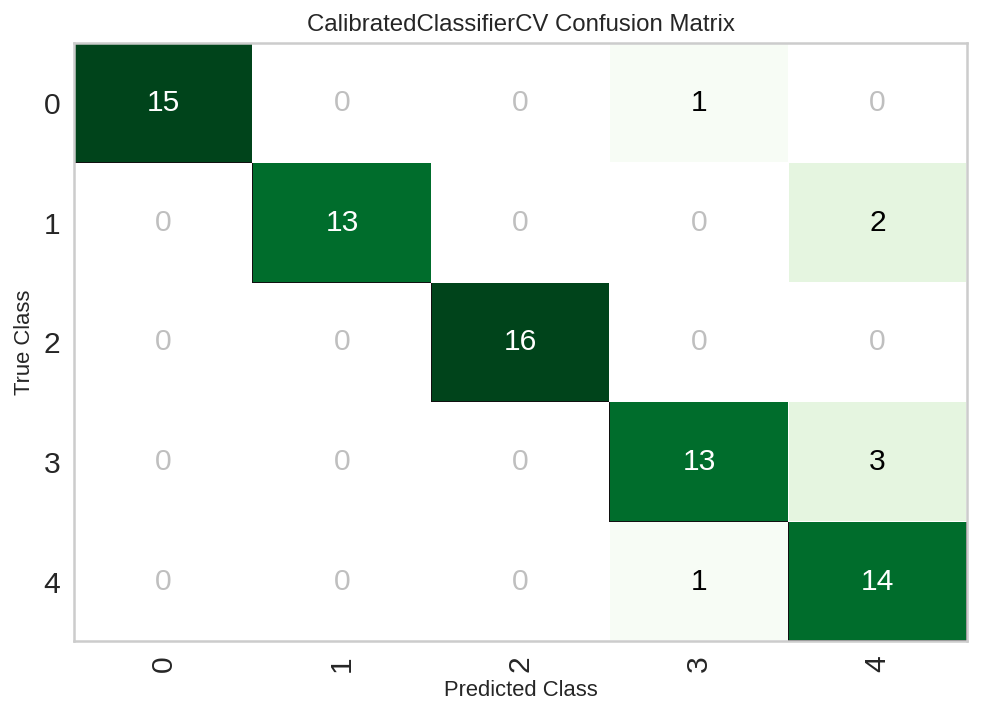

In [ ]:
plot_model(
    calibrated_model,
    plot='confusion_matrix'
)

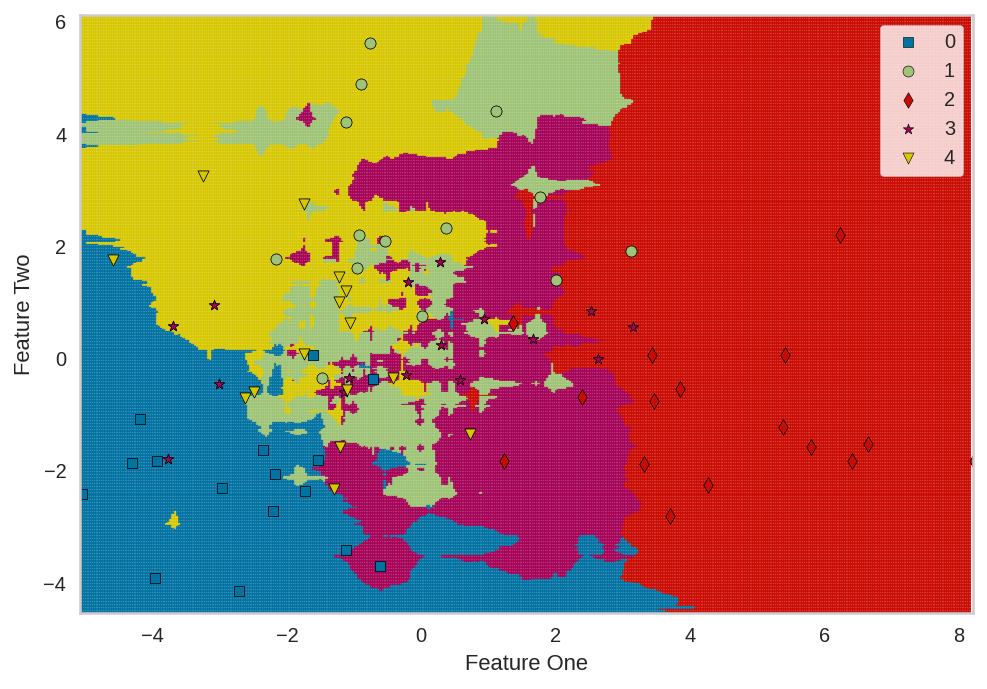

In [ ]:
plot_model(
    calibrated_model,
    plot='boundary'
)

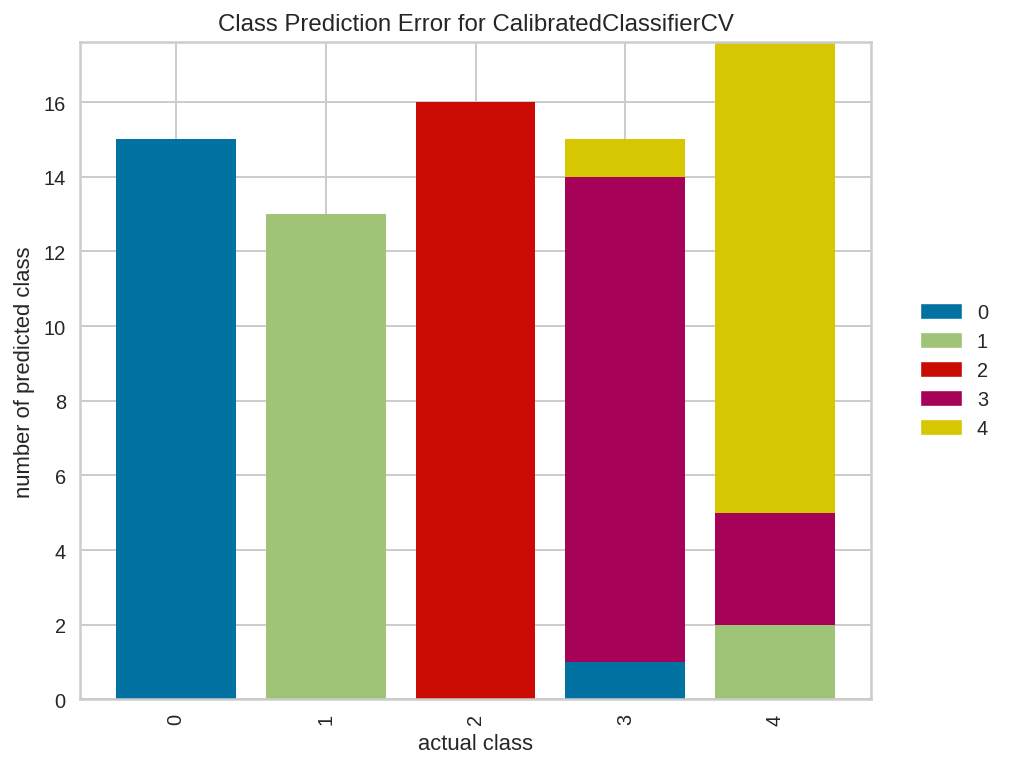

In [ ]:
plot_model(
    calibrated_model,
    plot='error'
)